# SSBU VOD helper

Insert your URL and click _Run after_ (Ctrl + F10 OR Runtime -> Run after) to get your output.

Note: please use either Youtube OR Twitch at once.


## Dependencies

Imports dependencies.


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os.path
from pathlib import Path
from tensorflow.keras.models import load_model # type: ignore
import subprocess
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import glob

try:
    import ffmpeg
except ModuleNotFoundError:
    subprocess.run(["pip", "-q", "install", "ffmpeg-python"])
    import ffmpeg

# load model from directory
model = load_model("./model")

# source url/directory
youtube_url = "" 

twitch_url = ""
twitch_url = "https://www.twitch.tv/videos/1951643050"

# input_file = Path("/home/impasse/Desktop/2023-09-30_1938940058_altomaretournaments_il_re_dellarena_assedio_cybernetico.mkv")
# input_file = Path("2023-09-16_1926971349_smashbrositalia_smash_class_36_feat_nfl_midoriss_jix_bosco_more.mp4")

2023-10-16 18:24:26.572949: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 18:24:26.764259: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-16 18:24:26.764301: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-16 18:24:26.764344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-16 18:24:26.818887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 18:24:26.819427: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

### Download from YouTube


In [2]:
try:
    import pytube
except ModuleNotFoundError:
    subprocess.run(["pip", "-q", "install", "pytube"])
    import pytube


if youtube_url:
    yt = pytube.YouTube(youtube_url.replace("watch?v=", ""))
    yt = (
        yt.streams.filter(progressive=True, file_extension="mp4")
        .order_by("resolution")
        .desc()
        .first()
    )

    if not os.path.exists("."):
        os.makedirs(".")

    yt.download(".")

### Download from Twitch


In [3]:
if twitch_url:
  !pip -q install twitch-dl
  !twitch-dl download $twitch_url -q 160p -f mp4
  # !twitch-dl download -q source -f mp4 $twitch_url

/bin/bash: line 1: pip: command not found
Looking up video...
Found: AltoMare Z - La Scomparsa di Chrono ft. Forze, Sasyzza, Zio Al and more! by SmashBrosItalia
Output: 2023-10-15_1951643050_smashbrositalia_altomare_z_la_scomparsa_di_chrono_ft_forze_sasyzza_zio_al_and_more.mp4
Fetching access token...
Fetching playlists...
Fetching playlist...

Downloaded 2310/2312 VODs 99% of ~785.5MB at 5.2MB/s ETA 00:00     

Joining files...
ffmpeg -i /tmp/twitch-dl/8601f7017df4e2f1ffda_smashbrositalia_40060147925_1697372869/160p30/playlist_downloaded.m3u8 -c copy -metadata artist=SmashBrosItalia -metadata title=AltoMare Z - La Scomparsa di Chrono ft. Forze, Sasyzza, Zio Al and more! -metadata encoded_by=twitch-dl -stats -loglevel warning file:2023-10-15_1951643050_smashbrositalia_altomare_z_la_scomparsa_di_chrono_ft_forze_sasyzza_zio_al_and_more.mp4
frame=693475 fps=32142 q=-1.0 Lsize=  680401kB time=06:25:16.76 bitrate= 241.1kbits/s speed=1.07e+03x    

Deleting temporary files...

Downloaded: 20

## Directories handling

Creates snapshots folder and video-specific subfolders starting from the last added (downloaded) file.


In [4]:
if twitch_url or youtube_url:
    # orders files by last added in order to grab last .mp4 file
    files = list(filter(os.path.isfile, glob.glob("*")))
    files.sort(key=lambda x: ".mp4" in x and os.path.getmtime(x))

    # handle situation in which no file is present
    if not files:
        raise Exception("An error has occurred: no video files in directory.")

    # get latest added file and set directory name
    input_file = files[-1]
    dir_name = input_file.replace(".mp4", "")

input_file = Path(input_file)

dataframes_dir = Path(f"./data/dataframes/{input_file.name}")
plots_dir = Path(f"./data/plots/{input_file.name}")
timestamps_dir = Path(f"./data/timestamps/{input_file.name}")
snapshots_dir = Path(f"./data/snapshots/{input_file.name}")

try:
    os.mkdir(dataframes_dir)
    os.mkdir(plots_dir)
    os.mkdir(timestamps_dir)
    os.mkdir(snapshots_dir)
except FileExistsError:
    print(f"Data directories already exist for {input_file.name}")

## Video to frames conversion

Uses `ffmpeg-python` to convert a video file to a succession of frames from the same video, grabbing one frame each second and resizing it to 426x240. **This process will take a lot of time** depending on the length of the video, so sit tight.


In [5]:
if not len(glob.glob(f"{snapshots_dir}/**")) > 0:
    print(f"Processing: {input_file}")
    try:
        (
            ffmpeg.input(input_file)
            .filter("fps", fps=1)
            .output(
                f"{snapshots_dir}/%d.jpg",
                s='426x240',
                start_number=0,
            )
            .run(capture_stdout=True, capture_stderr=True)
        )
    except ffmpeg.Error as e:
        print("stdout:", e.stdout.decode("utf8"))
        print("stderr:", e.stderr.decode("utf8"))
else:
    print(f"Snapshots already exist for {input_file}; skipping.")

Processing: 2023-10-15_1951643050_smashbrositalia_altomare_z_la_scomparsa_di_chrono_ft_forze_sasyzza_zio_al_and_more.mp4


## Frames prediction

Defines `predict_screen` which handles each frame (resizing, normalization, etc.) and then predicts its label. This will also take a lot of time.


In [6]:
def predict_screen(img_dir, labels):# -> dict[Any | str, Any]:
    img = tf.keras.preprocessing.image.load_img(
        img_dir, target_size=(224, 224)  # inputs directory  # resizes images
    )

    # (height, width, channels)
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)

    # (1, height, width, channels), add a dimension because the model
    # expects this shape: (batch_size, height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    # normalization
    img_tensor /= 255.0

    # predicts the label of the test_images
    predictions = model.predict(img_tensor)

    # gets label with highest confidence
    prediction_index = np.argmax(predictions, axis=1)[0]
    label = labels[prediction_index]

    # uses original file's name as output name
    output_name = img_dir.split("/")[-1]

    return {output_name: label, "confidence": predictions[0][0]}

In [7]:
# labels definition
labels = {
    0: "gameplay",
    1: "junk",
}

if len(glob.glob(f"{dataframes_dir}/**")) > 0: 
    raise Exception("Predictions already exist for this vod; skipping.")

# construct a dataframe to hold the predictions
predictions_df = pd.DataFrame([], columns=["Frame", "Label", "Confidence"])
for f in os.listdir(snapshots_dir):
    if f not in labels.values():
        prediction = predict_screen(rf"{snapshots_dir}/{f}", labels)

        pred_dir = prediction[f]

        new_row = pd.DataFrame(
            [
                {
                    "Frame": int(f.replace(".jpg", "")),
                    "Label": prediction[f],
                    "Confidence": prediction["confidence"],
                }
            ]
        )

        predictions_df = pd.concat([predictions_df, new_row])

1/1 [==============================] - 0s 24ms/step


## Features engineering

In [8]:
# ensure frame has a numeric type and sort
predictions_df["Frame"] = predictions_df["Frame"].astype("int64")
predictions_df = predictions_df.sort_values(by="Frame")

# create a timestamp column
predictions_df["Timestamp"] = pd.to_datetime(predictions_df["Frame"], unit='s')

predictions_df.to_csv(f"{dataframes_dir}/predictions_raw.csv", index=False)

In [9]:
predictions_df = pd.read_csv(f"{dataframes_dir}/predictions_raw.csv")
predictions_df

,Frame,Label,Confidence,Timestamp
0,0,junk,0.001514,1970-01-01 00:00:00
1,1,junk,0.000675,1970-01-01 00:00:01
2,2,junk,0.001532,1970-01-01 00:00:02
3,3,junk,0.001185,1970-01-01 00:00:03
4,4,junk,0.001391,1970-01-01 00:00:04
...,...,...,...,...
23111,23111,junk,0.000697,1970-01-01 06:25:11
23112,23112,junk,0.007462,1970-01-01 06:25:12
23113,23113,junk,0.000332,1970-01-01 06:25:13
23114,23114,junk,0.002020,1970-01-01 06:25:14


In [10]:
# construct a Duration column, used to implement thresholding later
prev_label = predictions_df.iloc[0]["Label"]
prev_label_idx, duration = 0, 0
for i, r in predictions_df.iterrows():
    if prev_label != r["Label"]:
        predictions_df.loc[prev_label_idx : (prev_label_idx + duration), "Duration"] = duration  # type: ignore


        prev_label = r["Label"]
        prev_label_idx = i

        duration = 0

    duration += 1

# export to csv
predictions_df.to_csv(f"{dataframes_dir}/predictions.csv", index=False)

In [11]:
predictions_df

,Frame,Label,Confidence,Timestamp,Duration
0,0,junk,0.001514,1970-01-01 00:00:00,156.0
1,1,junk,0.000675,1970-01-01 00:00:01,156.0
2,2,junk,0.001532,1970-01-01 00:00:02,156.0
3,3,junk,0.001185,1970-01-01 00:00:03,156.0
4,4,junk,0.001391,1970-01-01 00:00:04,156.0
...,...,...,...,...,...
23111,23111,junk,0.000697,1970-01-01 06:25:11,NaN
23112,23112,junk,0.007462,1970-01-01 06:25:12,NaN
23113,23113,junk,0.000332,1970-01-01 06:25:13,NaN
23114,23114,junk,0.002020,1970-01-01 06:25:14,NaN


## Handling predictions

In [12]:
predictions_df = pd.read_csv(f"{dataframes_dir}/predictions.csv", parse_dates=["Timestamp"])

# save number of rows to measure thresholding later
old_n_rows = predictions_df.shape[0]

predictions_df

,Frame,Label,Confidence,Timestamp,Duration
0,0,junk,0.001514,1970-01-01 00:00:00,156.0
1,1,junk,0.000675,1970-01-01 00:00:01,156.0
2,2,junk,0.001532,1970-01-01 00:00:02,156.0
3,3,junk,0.001185,1970-01-01 00:00:03,156.0
4,4,junk,0.001391,1970-01-01 00:00:04,156.0
...,...,...,...,...,...
23111,23111,junk,0.000697,1970-01-01 06:25:11,NaN
23112,23112,junk,0.007462,1970-01-01 06:25:12,NaN
23113,23113,junk,0.000332,1970-01-01 06:25:13,NaN
23114,23114,junk,0.002020,1970-01-01 06:25:14,NaN


### Handling games

In [13]:
# threshold intensity 
threshold = 15

# apply thresholding
predictions_df = predictions_df.drop(predictions_df[predictions_df["Duration"] < threshold].index)

print(f"{old_n_rows - predictions_df.shape[0]} rows removed by thresholding.")

predictions_df

673 rows removed by thresholding.


,Frame,Label,Confidence,Timestamp,Duration
0,0,junk,0.001514,1970-01-01 00:00:00,156.0
1,1,junk,0.000675,1970-01-01 00:00:01,156.0
2,2,junk,0.001532,1970-01-01 00:00:02,156.0
3,3,junk,0.001185,1970-01-01 00:00:03,156.0
4,4,junk,0.001391,1970-01-01 00:00:04,156.0
...,...,...,...,...,...
23111,23111,junk,0.000697,1970-01-01 06:25:11,NaN
23112,23112,junk,0.007462,1970-01-01 06:25:12,NaN
23113,23113,junk,0.000332,1970-01-01 06:25:13,NaN
23114,23114,junk,0.002020,1970-01-01 06:25:14,NaN


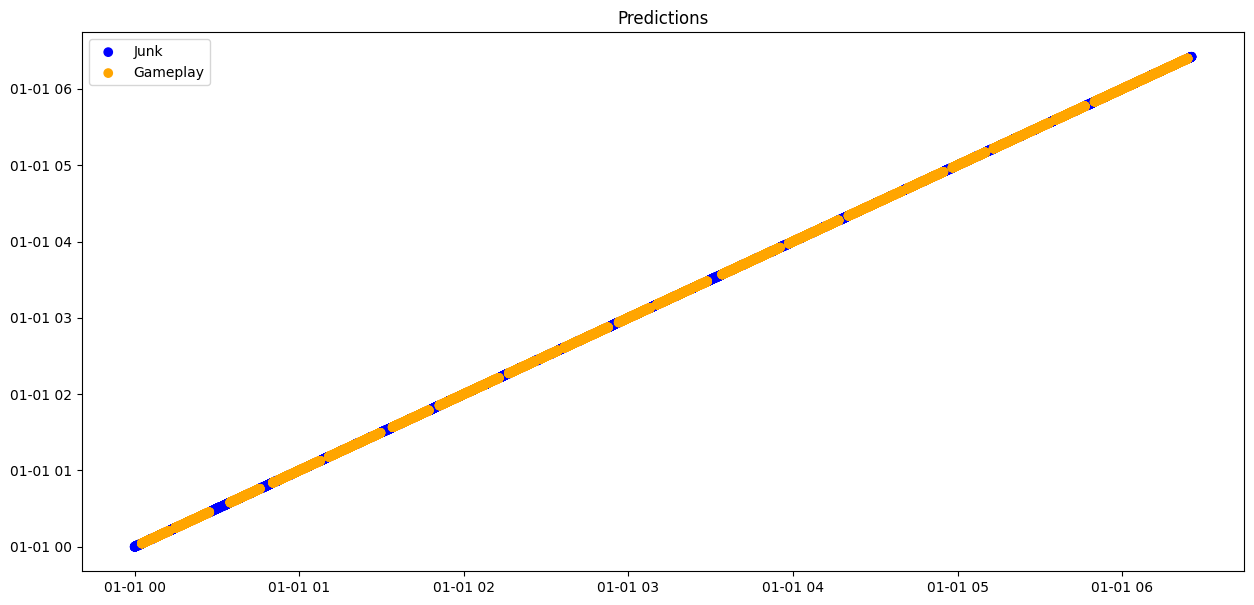

In [14]:
predictions_df["Color"] = np.where(predictions_df["Label"] == "gameplay", "orange", "blue")

gameplay = predictions_df[predictions_df["Label"] == 'gameplay']
junk = predictions_df[predictions_df["Label"] == 'junk']

figure = plt.figure(figsize=(15, 7))

plt.title("Predictions")
plt.scatter(x=junk["Timestamp"], y=junk["Timestamp"], c=junk["Color"])
plt.scatter(x=gameplay["Timestamp"], y=gameplay["Timestamp"], c=gameplay["Color"])
plt.legend(['Junk', 'Gameplay'])

plt.savefig(f"{plots_dir}/predictions.png")

### Handling sets

In [15]:
def group_labels(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Groups any consecutive timestamp with the same label in a single entry.
    The entry is then filled with "Start Time" and "End Time", each containing
    information about when the label changed. Returns a labeled dataframe.
    """

    # creates an empty segments dataframe
    segments = pd.DataFrame(columns=["Label", "Start Time", "End Time"])

    # initial start time
    start_time = df.iloc[0]["Timestamp"]

    for i in range(df.shape[0]):
        try:
            # slices the df whenever a new label is encountered
            if df.iloc[i][col_name] != df.iloc[i + 1][col_name]:
                duration = df.iloc[i]["Timestamp"] - start_time

                segments = pd.concat(
                    [
                        segments,
                        pd.DataFrame(
                            [
                                {
                                    "Label": df.iloc[i]["Label"],
                                    "Start Time": start_time,
                                    "End Time": df.iloc[i]["Timestamp"],
                                    "Duration": duration,
                                }
                            ],
                        ),
                    ]
                )

                # new start time
                start_time = df.iloc[i]["Timestamp"]

        except IndexError:
            # handles the last entry
            duration = df.iloc[i]["Timestamp"] - start_time

            segments = pd.concat(
                [
                    segments,
                    pd.DataFrame(
                        [
                            {
                                "Label": df.iloc[i]["Label"],
                                "Start Time": start_time,
                                "End Time": df.iloc[i]["Timestamp"],
                                "Duration": duration,
                            }
                        ],
                    ),
                ]
            )

            # new start time
            start_time = df.iloc[i]["Timestamp"]

    return segments

In [16]:
predictions_df

,Frame,Label,Confidence,Timestamp,Duration,Color
0,0,junk,0.001514,1970-01-01 00:00:00,156.0,blue
1,1,junk,0.000675,1970-01-01 00:00:01,156.0,blue
2,2,junk,0.001532,1970-01-01 00:00:02,156.0,blue
3,3,junk,0.001185,1970-01-01 00:00:03,156.0,blue
4,4,junk,0.001391,1970-01-01 00:00:04,156.0,blue
...,...,...,...,...,...,...
23111,23111,junk,0.000697,1970-01-01 06:25:11,NaN,blue
23112,23112,junk,0.007462,1970-01-01 06:25:12,NaN,blue
23113,23113,junk,0.000332,1970-01-01 06:25:13,NaN,blue
23114,23114,junk,0.002020,1970-01-01 06:25:14,NaN,blue


In [17]:
games_df = group_labels(predictions_df, "Label")

# create a colur column for visualization purposes
games_df["Color"] = np.where(games_df["Label"] == "gameplay", "orange", "blue")

games_df.head(10)

,Label,Start Time,End Time,Duration,Color
0,junk,1970-01-01 00:00:00,1970-01-01 00:02:35,0 days 00:02:35,blue
0,gameplay,1970-01-01 00:02:35,1970-01-01 00:05:44,0 days 00:03:09,orange
0,junk,1970-01-01 00:05:44,1970-01-01 00:06:30,0 days 00:00:46,blue
0,gameplay,1970-01-01 00:06:30,1970-01-01 00:08:47,0 days 00:02:17,orange
0,junk,1970-01-01 00:08:47,1970-01-01 00:09:19,0 days 00:00:32,blue
0,gameplay,1970-01-01 00:09:19,1970-01-01 00:12:35,0 days 00:03:16,orange
0,junk,1970-01-01 00:12:35,1970-01-01 00:14:44,0 days 00:02:09,blue
0,gameplay,1970-01-01 00:14:44,1970-01-01 00:19:00,0 days 00:04:16,orange
0,junk,1970-01-01 00:19:00,1970-01-01 00:19:25,0 days 00:00:25,blue
0,gameplay,1970-01-01 00:19:25,1970-01-01 00:27:11,0 days 00:07:46,orange


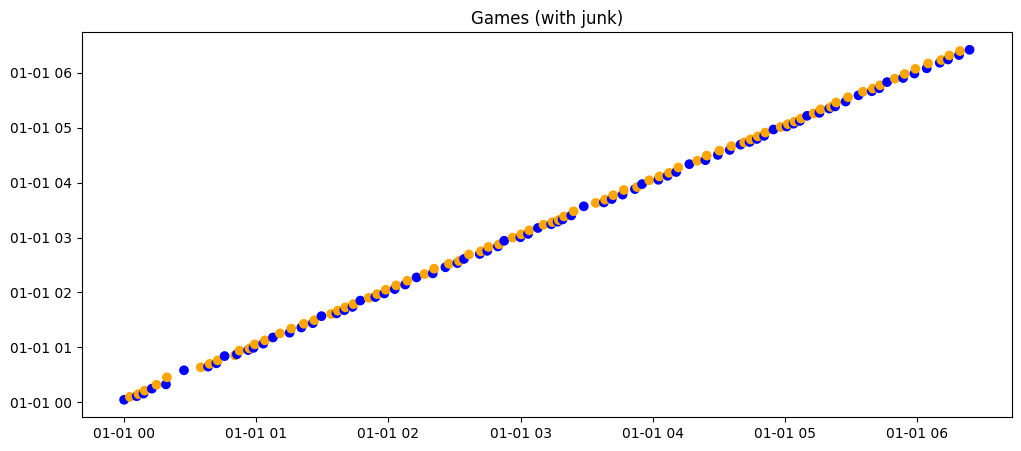

In [18]:
plt.figure(num=None, figsize=(12, 5))
plt.title("Games (with junk)")

# reminder: blue = junk, orange = gameplay
plt.scatter(
    x=games_df["Start Time"], y=games_df["End Time"], c=games_df["Color"]
)

plt.savefig(f"{plots_dir}/games_w_junk.png")

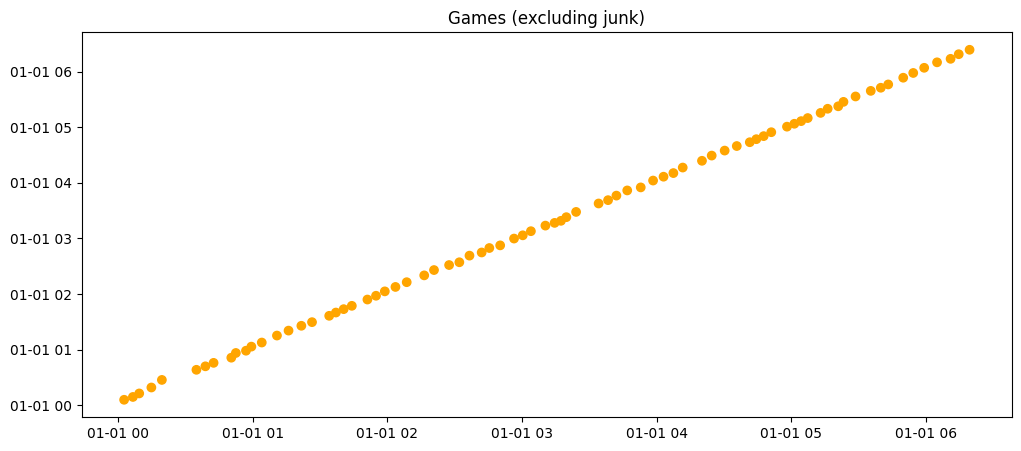

In [19]:
games_df = games_df[games_df["Label"] == "gameplay"]

plt.figure(num=None, figsize=(12, 5))
plt.title("Games (excluding junk)")
plt.scatter(x=games_df["Start Time"], y=games_df["End Time"], c=games_df["Color"])

plt.savefig(f"{plots_dir}/games_no_junk.png")

In [20]:
games_df.to_csv(f"{dataframes_dir}/games.csv", index=False)

## Clustering


In [21]:
games_df = pd.read_csv(f"{dataframes_dir}/games.csv", parse_dates=["Start Time", "End Time"])
games_df.head(10)

,Label,Start Time,End Time,Duration,Color
0,gameplay,1970-01-01 00:02:35,1970-01-01 00:05:44,0 days 00:03:09,orange
1,gameplay,1970-01-01 00:06:30,1970-01-01 00:08:47,0 days 00:02:17,orange
2,gameplay,1970-01-01 00:09:19,1970-01-01 00:12:35,0 days 00:03:16,orange
3,gameplay,1970-01-01 00:14:44,1970-01-01 00:19:00,0 days 00:04:16,orange
4,gameplay,1970-01-01 00:19:25,1970-01-01 00:27:11,0 days 00:07:46,orange
5,gameplay,1970-01-01 00:34:49,1970-01-01 00:38:07,0 days 00:03:18,orange
6,gameplay,1970-01-01 00:38:49,1970-01-01 00:41:53,0 days 00:03:04,orange
7,gameplay,1970-01-01 00:42:28,1970-01-01 00:45:37,0 days 00:03:09,orange
8,gameplay,1970-01-01 00:50:22,1970-01-01 00:51:12,0 days 00:00:50,orange
9,gameplay,1970-01-01 00:52:24,1970-01-01 00:56:18,0 days 00:03:54,orange


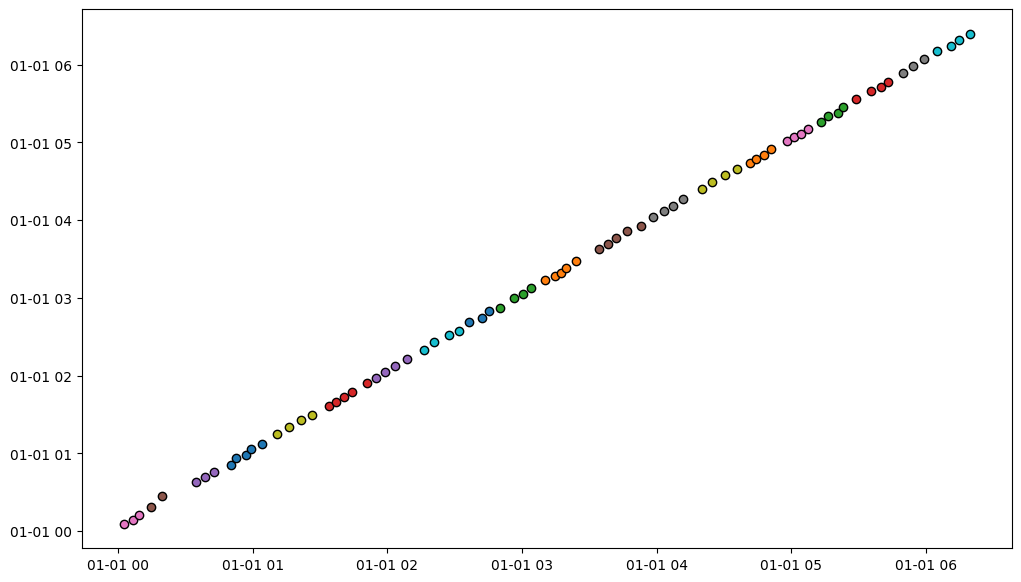

In [24]:
n_clusters = 20

# exclude junk labels
games_df = games_df[games_df["Label"] == "gameplay"]

# setup KMeans
kmeans = KMeans(
    n_clusters=n_clusters,
    n_init=10,
)

# specify X and Y axis and compute clusters
labels = kmeans.fit_predict(games_df[["Start Time", "End Time"]])

# add clusters to dataframe for easy handling
games_df["Cluster"] = labels

# plot clustering
clusters_labels = [games_df[labels == i] for i in range(n_clusters)]

plt.figure(figsize=(12, 7))

for i in range(len(clusters_labels)):
    plt.scatter(
        x=clusters_labels[i]["Start Time"],
        y=clusters_labels[i]["End Time"],
        edgecolors="black",
    )

plt.show()

In [26]:
from datetime import timedelta


title = "Altomare Z - La Scomparsa di Chrono"

# additional time to sum/subtract from start/end timestamp
buffer = 7

ts_output_dir = Path(f"{timestamps_dir}/{title.replace(' ', '_')}.md")

if ts_output_dir.exists():
    print("File already exists: loading from disk.\n")

    with open(ts_output_dir) as ts_output:
        ts_output = ts_output.readlines()

    print(''.join(ts_output))

else: 
    timestamps_file = ""
    for idx in games_df["Cluster"].unique():
        start = games_df[games_df["Cluster"] == idx].iloc[0]["Start Time"] + timedelta(seconds=-buffer)
        end = games_df[games_df["Cluster"] == idx].iloc[-1]["End Time"] + timedelta(seconds=+buffer)


        timestamp_line = f"{title} | Pools - player1 (char1) vs player2 (char2) -- {str(start)[11:]} - {str(end)[11:]}\n"
        timestamps_file += timestamp_line

        print(timestamp_line, end='')

    # save timestamps string to disk
    with open(ts_output_dir, 'w') as ts_output:
        ts_output.write(timestamps_file)

Altomare Z - La Scomparsa di Chrono | Pools - player1 (char1) vs player2 (char2) -- 00:02:28 - 00:12:42
Altomare Z - La Scomparsa di Chrono | Pools - player1 (char1) vs player2 (char2) -- 00:14:37 - 00:27:18
Altomare Z - La Scomparsa di Chrono | Pools - player1 (char1) vs player2 (char2) -- 00:34:42 - 00:45:44
Altomare Z - La Scomparsa di Chrono | Pools - player1 (char1) vs player2 (char2) -- 00:50:15 - 01:07:42
Altomare Z - La Scomparsa di Chrono | Pools - player1 (char1) vs player2 (char2) -- 01:10:36 - 01:29:43
Altomare Z - La Scomparsa di Chrono | Pools - player1 (char1) vs player2 (char2) -- 01:33:54 - 01:54:09
Altomare Z - La Scomparsa di Chrono | Pools - player1 (char1) vs player2 (char2) -- 01:54:46 - 02:12:53
Altomare Z - La Scomparsa di Chrono | Pools - player1 (char1) vs player2 (char2) -- 02:16:15 - 02:34:25
Altomare Z - La Scomparsa di Chrono | Pools - player1 (char1) vs player2 (char2) -- 02:36:26 - 02:49:48
Altomare Z - La Scomparsa di Chrono | Pools - player1 (char1) vs